In [1]:
# Kafka configuration
kafka_config = {
    "bootstrap_servers": "kafka1:9092",  # Update with your Kafka broker
}

In [2]:
C6_BUS_STOPS = ["HERM", "PLCL", "APRE", "TILL", "DERV", "LNAI", "PEON", "SLAU", "VARI", "PCRE", "PRCE", "DOME", "CMUS", "MDSI", "HARO", "DLME", "SNIC", "CRQU", "HVNA", "STPI", "FOCH", "BOND", "COCH", "BTEC", "LALL", "CLTT", "COUD", "BEMZ", "GDRE", "ERDI", "KERE", "PCVO", "KOUF", "RAZA", "BATI", "BJOI", "RSRA", "LNTT", "PTQQ", "EMBE", "SJPO", "CCAN", "MDPO", "CTRE"]
C6_BUS_STOPS_SENS2 = C6_BUS_STOPS[::-1]


Matplotlib is building the font cache; this may take a moment.


:: loading settings :: url = jar:file:/opt/conda/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8db18666-9c70-4bca-ac71-b63f24bd4af3;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.3 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.3 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	

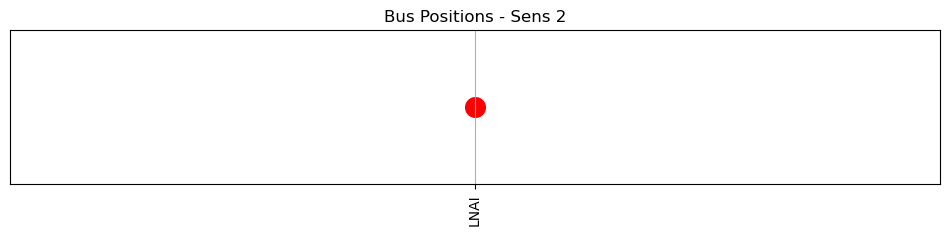

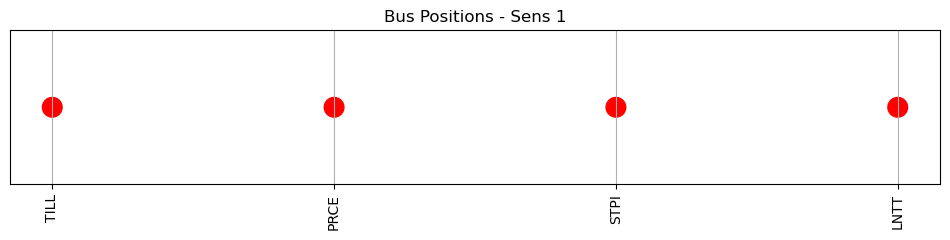

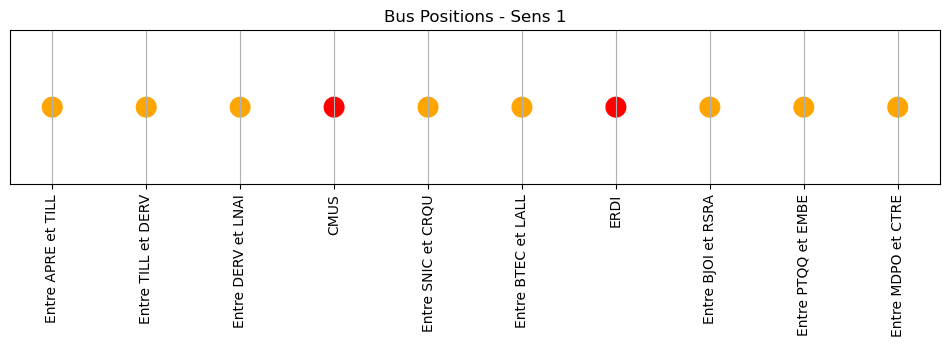

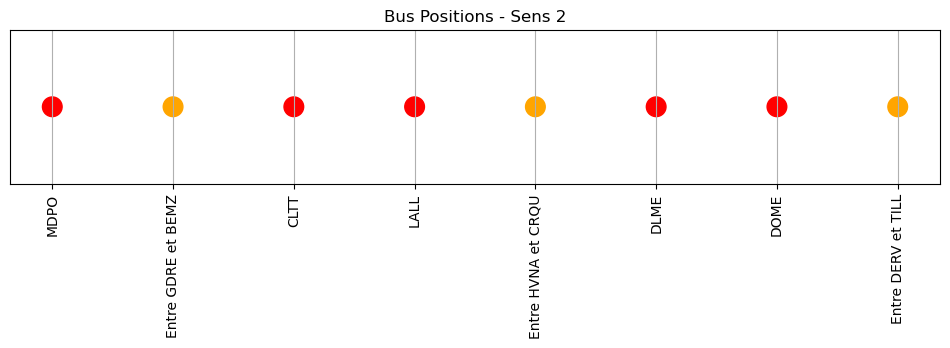

ERROR:root:Exception while sending command.                        (0 + 1) / 10]
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: reentrant call inside <_io.BufferedReader name=60>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/py

Py4JError: An error occurred while calling o128.awaitTermination

25/03/18 15:38:37 ERROR StandaloneSchedulerBackend: Application has been killed. Reason: Master removed our application: KILLED


In [ ]:

from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql.functions import from_json, col, current_timestamp, lit, struct, array, udf, collect_list, asc, window, when, regexp_replace
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, ArrayType, TimestampType
import matplotlib.pyplot as plt
import pandas as pd

conf = SparkConf() \
    .setAppName('SparkApp') \
    .setMaster('spark://spark:7077') \
    .set("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.3") \
    .set("spark.sql.shuffle.partitions", "10")
 

sc = SparkContext.getOrCreate(conf=conf)

# Créer un SQLContext pour les opérations SQL
sql_context = SQLContext(sc)

schema = StructType([
    StructField("sens", IntegerType(), True),
    StructField("terminus", StringType(), True),
    StructField("infotrafic", BooleanType(), True),
    StructField("temps", StringType(), True),
    StructField("tempsReel", StringType(), True),
    StructField("stop", StringType(), True),
    StructField("numLigne", StringType(), True),
    StructField("created_at", StringType(), True)
])

# Read raw data from Kafka
raw_stream = sql_context.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_config["bootstrap_servers"]) \
    .option("subscribe", "bus_position") \
    .option("startingOffsets", "latest") \
    .load()

parsed_stream = raw_stream \
    .select(from_json(col("value").cast("string"), schema).alias("data")) \
    .select(
        col("data.sens").alias("sens"),
        col("data.terminus").alias("terminus"),
        col("data.infotrafic").alias("infotrafic"),
        col("data.temps").alias("temps"),
        col("data.tempsReel").alias("tempsReel"),
        col("data.stop").alias("stop"),
        col("data.numLigne").alias("numLigne"),
        col("data.created_at").cast(TimestampType()).alias("created_at")
    ) \
    .filter( \
        col("tempsReel") == "true" \
    ).withColumn(
        "minutes",
        when(col("temps") == "proche", 0)  # Si "proche", retourne 0
        .otherwise(
            regexp_replace(col("temps"), "mn", "").cast("int")  # Sinon, enlève "mn" et cast en int
    )
)

# Ajouter watermark et fenêtre temporelle de 1 minute
windowed_stream = parsed_stream \
    .withWatermark("created_at", "1 minute") \
    .groupBy(
        window("created_at", "1 minute"),
        col("sens")
    ) \
    .agg(collect_list(struct(col("stop"), col("minutes"))).alias("stops"))

# Fonction UDF pour détecter la position des bus sur une ligne ordonnée
def detect_bus_positions(stops, stops_list):
    result = []
    for idx, stop in enumerate(stops_list):
        current = next((x for x in stops if x["stop"] == stop), None)
        prev = next((x for x in stops if x["stop"] == stops_list[idx - 1]), None) if idx > 0 else None

        if current and current["minutes"] == 0:
            result.append((stop, "BUS ICI"))
        elif current and prev and current["minutes"] > 0 and prev["minutes"] > current["minutes"]:
            result.append((f"Entre {stops_list[idx - 1]} et {stop}", "BUS ENTRE"))
    return result

schema_result = ArrayType(StructType([
    StructField("location", StringType(), False),
    StructField("status", StringType(), False)
]))

detect_bus_positions_udf = udf(lambda stops, sens: detect_bus_positions(
    stops,
    C6_BUS_STOPS if sens == 1 else C6_BUS_STOPS_SENS2
), schema_result)

# Appliquer l'UDF sur l'agrégation
bus_positions = windowed_stream.withColumn("positions", detect_bus_positions_udf(col("stops"), col("sens")))

def plot_bus_positions(df, batch_id):
    pandas_df = df.toPandas()

    for sens in pandas_df["sens"].unique():
        df_sens = pandas_df[pandas_df["sens"] == sens]
        positions = df_sens.iloc[0]["positions"]  # Liste de (location, status)

        stops_list = C6_BUS_STOPS if sens == 1 else C6_BUS_STOPS_SENS2

        plt.figure(figsize=(15, 2))
        plt.title(f"Bus Positions - Sens {sens}")

        # Affichage des arrêts
        y_stops = [0] * len(stops_list)
        plt.scatter(range(len(stops_list)), y_stops, c='gray', s=100, label='Arrêts')

        # Ajout des bus
        for position in positions:
            loc = position["location"]
            status = position["status"]

            if "Entre" in loc:
                prev_stop, next_stop = loc.replace("Entre ", "").split(" et ")
                idx_prev = stops_list.index(prev_stop)
                idx_next = stops_list.index(next_stop)
                idx = (idx_prev + idx_next) / 2  # Position entre deux arrêts
            else:
                idx = stops_list.index(loc)

            color = 'red' if status == "BUS ICI" else 'orange'
            plt.scatter([idx], [0], c=color, s=200, label=status if status not in plt.gca().get_legend_handles_labels()[1] else "")

        plt.xticks(range(len(stops_list)), stops_list, rotation=90)
        plt.yticks([])
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Afficher le résultat en streaming
# query = bus_positions.select(
#     col("sens"),
#     col("window.start").alias("window_start"),
#     col("window.end").alias("window_end"),
#     col("positions")
# ) \
# .writeStream \
# .outputMode("complete") \
# .format("console") \
# .option("truncate", "false") \
# .start()

query = bus_positions.writeStream \
    .foreachBatch(plot_bus_positions) \
    .outputMode("append") \
    .start()

query.awaitTermination()